# Project proposal

## Heart Disease Classification

## Introduction

A heart attack, also known as a myocardial infarction, occurs when blood flow to a part of the heart is blocked, usually by a blood clot. This can cause damage to the heart muscle, which can be life-threatening if not treated promptly. Risk factors for heart attack include smoking, high blood pressure, high cholesterol, obesity, physical inactivity, family history of heart disease, and diabetes. It's important to make lifestyle changes, such as quitting smoking, eating a healthy diet, exercising regularly, and managing any underlying medical conditions, to reduce your risk of heart attack.


Our aim with this project is to build a predictive model that can identify individuals at a high (`target = 1`) or low (`target = 0`) risk of developing heart disease using the KNN model with the predictors `age`, `trestbps`, `chol`, `thalach`, and `oldpeak`.

### About the dataset and its variables

This data set is collected from the Hungarian Institute of Cardiology, Budapest. It was donated in 1988 for analysis and diagnosis of heart disease in patients. This set of data has been used to generate a probability algorithm for the diagnosis of coronary artery disease. Past classifications with this data have acheived an accuracy around 77%.

**age** : Age of the patient

**sex** : Sex of the patient (0 = female ; 1 = male)

**exang**: exercise induced angina (1 = yes; 0 = no)

**ca**: number of major vessels (0-3) colored by flourosopy

**cp** : Chest Pain type 

* Value 0: typical angina

* Value 1: atypical angina

* Value 2: non-anginal pain

* Value 3: asymptomatic

**trtbps** : resting blood pressure (in mm Hg)

**chol** : cholestoral in mg/dl fetched via BMI sensor

**fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false).

**rest_ecg** : resting electrocardiographic results

* Value 0: normal

* Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

* Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

**thalach** : maximum heart rate achieved

**slope** : the slope of the peak exercise ST segment 
* 0: upsloping
* 1: flat 
* 2: downsloping

**oldpeak** :  ST depression induced by exercise relative to rest

**thal** :   1 = normal; 2 = fixed defect; 3 = reversable defect

**target** : 0 = less chance of heart attack ,  1 = more chance of heart attack

**We will only be using age, trestbps, chol, thalach and oldpeak as predictors in our classification.**

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Preliminary exploratory data analysis:

### Reading the data

In [33]:
heart_data <- read_csv("heart.csv")
heart_data <- heart_data[!(heart_data$thal==0 | heart_data$ca==4),]
heart_data |>
    head(10)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


### Selecting only intrested columns from data set

In [7]:
heart_data_clean <- select(heart_data, age, trestbps, chol, thalach, oldpeak, target) |> mutate(target = as_factor(target))
heart_data_clean |>
    head(10)

age,trestbps,chol,thalach,oldpeak,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,1.0,0
53,140,203,155,3.1,0
70,145,174,125,2.6,0
61,148,203,161,0.0,0
62,138,294,106,1.9,0
58,100,248,122,1.0,1
58,114,318,140,4.4,0
55,160,289,145,0.8,0
46,120,249,144,0.8,0


### Splitting data into training set and testing set

In [25]:
set.seed(2000)
heart_split <- initial_split(heart_data_clean, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

### Visualizations: Plotting graphs of all predictors and coloring them by the target variable

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



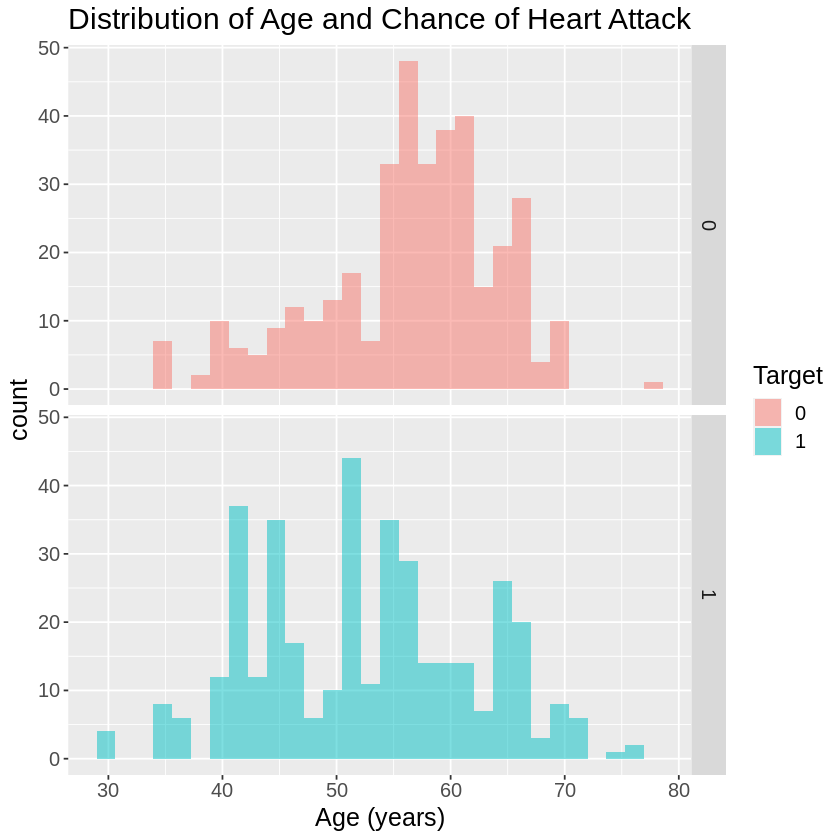

In [38]:
age_plot <- ggplot(heart_train, aes(x = age, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(target)) +
    labs(x = "Age (years)", fill = "Target") +
    ggtitle("Distribution of Age and Chance of Heart Attack") +
    theme(text = element_text(size = 15))
age_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



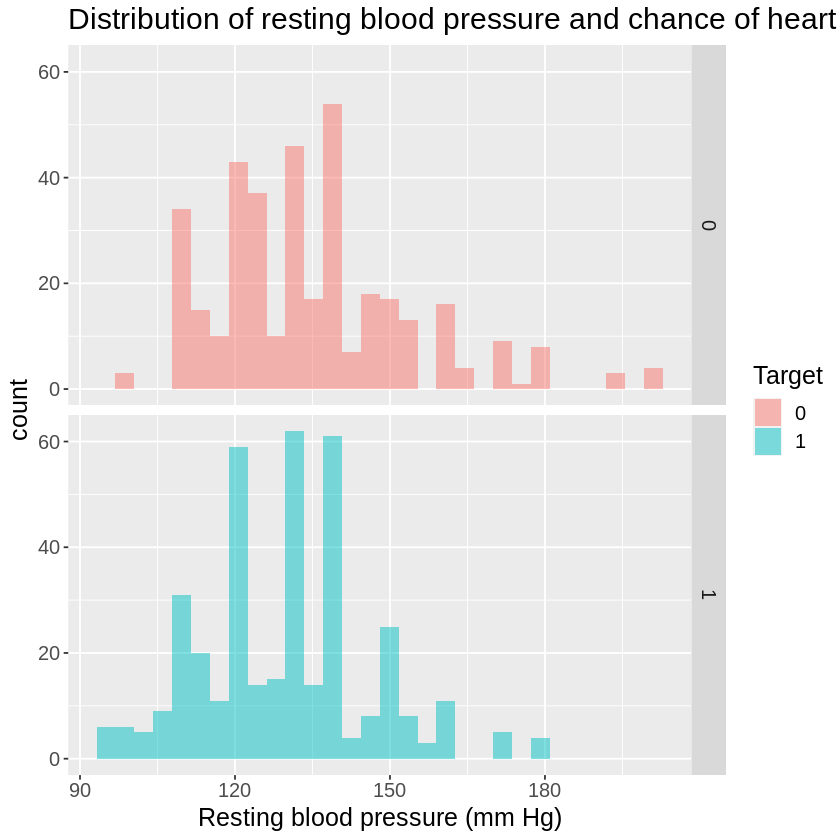

In [27]:
trestbps_plot <- ggplot(heart_train, aes(x = trestbps, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") + 
    facet_grid(rows = vars(target)) +
    labs(x = "Resting Blood Pressure (mm Hg)", fill = "Target") +
    ggtitle("Distribution of Resting Blood Pressure and Chance of Heart Attack") +
    theme(text = element_text(size = 15))
trestbps_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



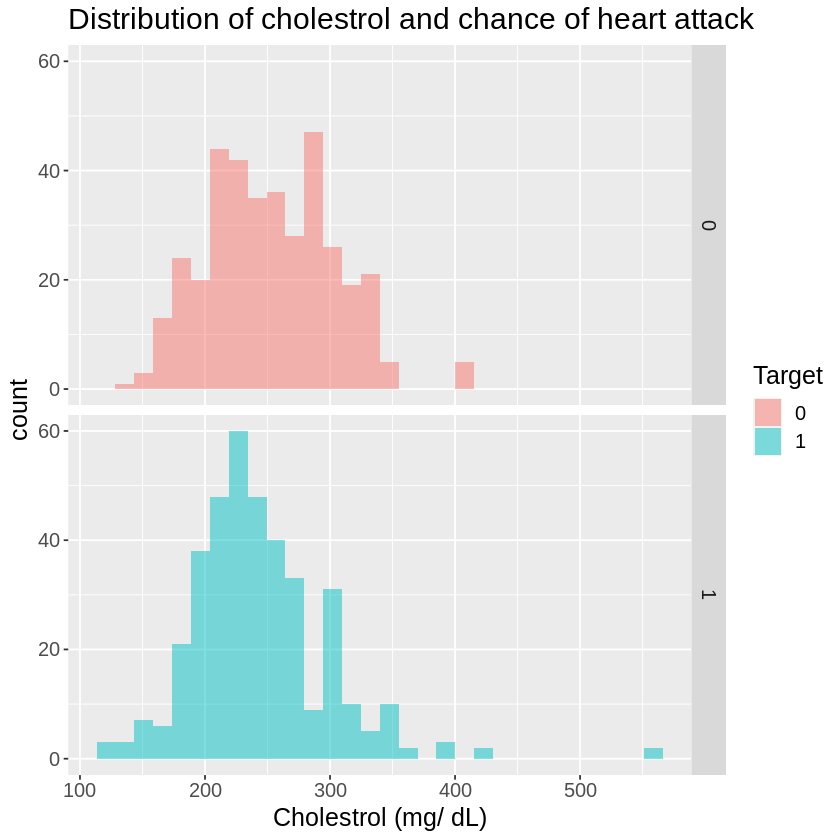

In [28]:
chol_plot <- ggplot(heart_train, aes(x = chol, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") + 
    facet_grid(rows = vars(target)) +
    labs(x = "Cholestrol (mg/ dL)", fill = "Target") +
    ggtitle("Distribution of Cholestrol and Chance of Heart Attack") +
    theme(text = element_text(size = 15))
chol_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



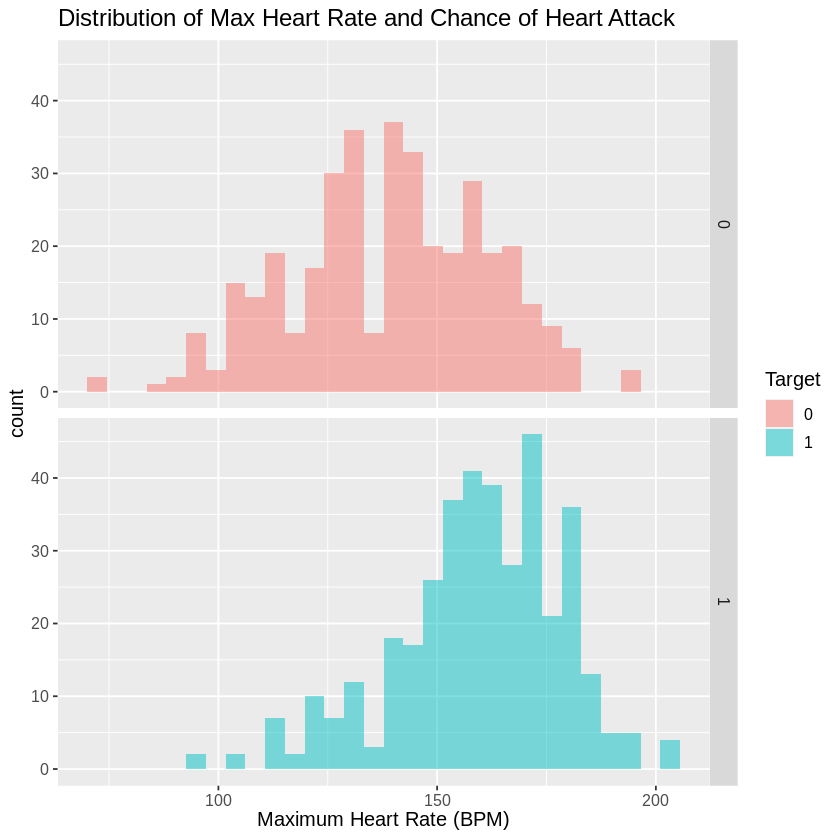

In [36]:
thalach_plot <- ggplot(heart_train, aes(x = thalach, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") + 
    facet_grid(rows = vars(target)) + 
    labs(x = "Maximum Heart Rate (BPM)", fill = "Target") +
    ggtitle("Distribution of Max Heart Rate and Chance of Heart Attack") +
    theme(text = element_text(size = 12))
thalach_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



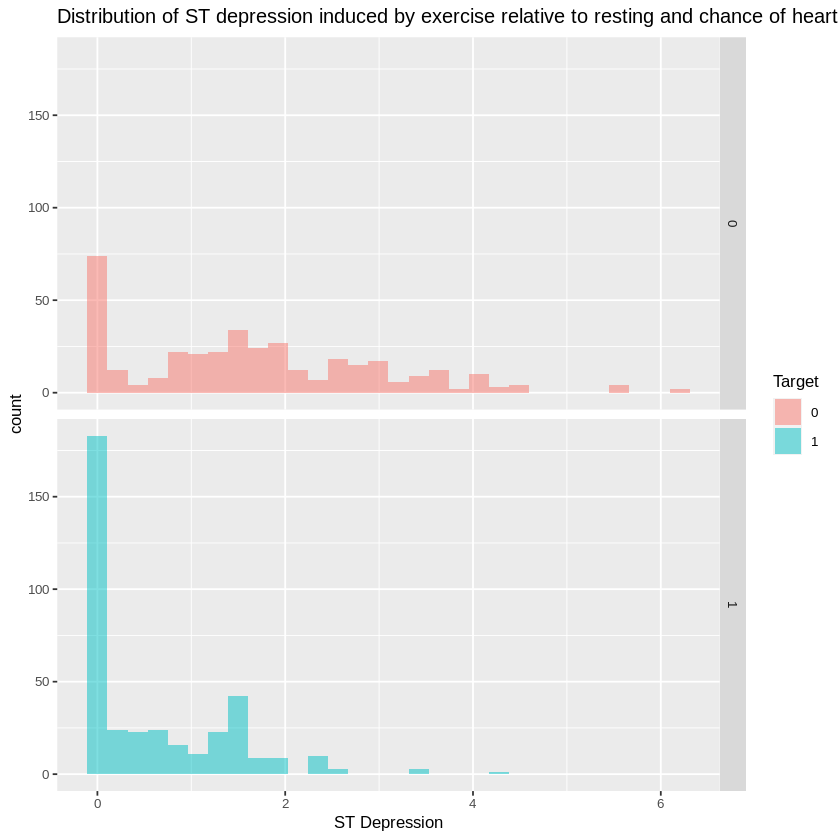

In [30]:
oldpeak_plot <- ggplot(heart_train, aes(x = oldpeak, fill = target)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    facet_grid(rows = vars(target)) +
    labs(x = "ST Depression", fill = "Target") +
    ggtitle("Distribution of ST depression induced by exercise relative to resting and chance of heart attack") +
    theme(text = element_text(size = 10))
oldpeak_plot

## Summary table

In [13]:
summary_table <- heart_train |>
    group_by(target) |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_trestbps = mean(trestbps,na.rm = TRUE),
              mean_chol = mean(chol,na.rm = TRUE),
              mean_thalach = mean(thalach,na.rm = TRUE),
              mean_oldpeak = mean(oldpeak,na.rm = TRUE),
              count = n())
summary_table

target,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,56.52846,134.8184,255.4932,138.6694,1.6143631,369
1,52.17060,128.4409,244.4987,159.7113,0.5721785,381


In [14]:
missing_table <- data.frame(Column_Names = colnames(heart_data), 
                            Missing_Values = colSums(is.na(heart_data)))
missing_table

,Column_Names,Missing_Values
,<chr>,<dbl>
age,age,0
sex,sex,0
cp,cp,0
trestbps,trestbps,0
chol,chol,0
fbs,fbs,0
restecg,restecg,0
thalach,thalach,0
exang,exang,0


We dont have any null or missing values in the dataset

## Methods

* We will classify `target` variable using the KNN model. Using `age`, `trestbps`, `chol`, `thalach` and `oldpeak` as predictors in our classification.
* All of these variables we chose are quantitative data. Looking at the preliminary visualizations, it appears that there are clear differences and similiarities in some attributes of the two categories of `target`. Since the 5 predictors we chose seem to have a good distribution with the target variable, we decided they are useful predictors and chose them.
* We plan on improving the classification accuracy by using 5 fold cross validation and tuning for fiding out the best value of k for which highest accuracy exists and make the prediction using that k value.
* One way we will visualize the results is by using confusion matrix to get the accuracy or the classification and plot a K vs. accuracy plot.


We will classify `target` variable using the KNN model. Using `age`, `trestbps`, `chol`, `thalach` and `oldpeak` as predictors in our classification. All of these variables we chose are quantitative data. Looking at the preliminary visualizations, it appears that there are clear differences and similiarities in some attributes of the two categories of `target`. Since the 5 predictors we chose seem to have a good distribution with the target variable, we decided they are useful predictors and chose them.

One way we will visualize the results is by using confusion matrix to get the accuracy or the classification and plot a K vs. accuracy plot.


## Expected outcomes and significance

**What do you expect to find?**
We expect to find whether an individual will have low or high chance of heart attack. 

**What impact could such findings have?**
These findings could be helpful in the medical sector in predicting heart attack instances in patients and take proper precaution/treatments to prevent it from happening.

**What future questions could this lead to?**
Many other questions can follow this one. Such as:
* What are the main risk factors associated with heart attacks?
* Are there any early warning signs that can indicate an impending heart attack?
* Can machine learning models be integrated into daily medical practice to improve early detection and prevention of heart attacks?
* What impact could integrating heart attack prediction models in the healthcare sector have on healthcare costs and patient health?